In [ ]:
### Import Libraries

In [1]:
# !pip install better-profanity
# !pip install seaborn
# !pip install contractions
# !pip install demoji
# !pip install scikit-learn
# !pip install detoxify
# !pip install vaderSentiment
# !pip install nltk
# !pip install chardet
# !pip install spacy
# !pip install flair
# !python -m spacy download en_core_web_lg
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.0.0/en_core_web_lg-3.0.0-py3-none-any.whl
# !conda install pytorch torchvision torchaudio cpuonly -c pytorch
# !pip install ipywidgets

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import json
import pickle

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm import tqdm_notebook

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
import re
import contractions
import nltk
# nltk.download('vader_lexicon') # Not with Jio Network
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from flair.data import Sentence
from flair.nn import Classifier

In [8]:
import demoji
from better_profanity import profanity

In [9]:
import spacy
from spacy.tokens import DocBin
import en_core_web_lg

In [10]:
from detoxify import Detoxify

### Sentiment Analysis

In [11]:
sent_texts = [
    "I love the new features in the latest update!",
    "The recent improvements to the user interface and the addition of exciting new features have significantly enhanced my overall experience with the product, making it more enjoyable and efficient to use on a daily basis.",
    "I am thrilled with the exceptional quality of service I received from this company. The product not only met but exceeded my expectations. The attention to detail, prompt customer support, and innovative solutions truly make it a standout in the market. I highly recommend it to anyone seeking a reliable and top-notch experience.",
    "The customer service was terrible.",
    "I had a very disappointing experience with the customer service team. Despite reaching out multiple times regarding a critical issue, the response was slow, unhelpful, and lacked any resolution. This has left me frustrated and dissatisfied with the overall service provided.",
    "Regrettably, my recent encounter with the product left me dissatisfied. The lack of responsiveness from the support team, coupled with unresolved issues, has significantly diminished my confidence in the product and the company as a whole. I hope for a swift resolution and improvement in customer service to regain my trust.",
    "The product meets my basic requirements.",
    "The product offers a standard set of features that align with my basic requirements. While it doesn't necessarily stand out in terms of innovation or uniqueness, it provides a functional and reliable solution for my everyday needs.",
    "In my experience, the product has proven to be a solid and dependable choice. It doesn't boast extravagant features, but it reliably fulfills its intended purpose. The user interface is straightforward, and I appreciate the simplicity it offers for seamless integration into my workflow."
]

In [12]:
sentiment1 = SentimentIntensityAnalyzer()

In [13]:
for text in sent_texts:
    print(text)
    text = " ".join(text.splitlines())
    sent = sentiment1.polarity_scores(text)
    print(sent, "\n")

I love the new features in the latest update!
{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.6696} 

The recent improvements to the user interface and the addition of exciting new features have significantly enhanced my overall experience with the product, making it more enjoyable and efficient to use on a daily basis.
{'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'compound': 0.8947} 

I am thrilled with the exceptional quality of service I received from this company. The product not only met but exceeded my expectations. The attention to detail, prompt customer support, and innovative solutions truly make it a standout in the market. I highly recommend it to anyone seeking a reliable and top-notch experience.
{'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'compound': 0.958} 

The customer service was terrible.
{'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.4767} 

I had a very disappointing experience with the customer service team. Despite reaching out multiple times regarding 

In [14]:
tagger = Classifier.load('sentiment')

In [17]:
s = Sentence(text)

In [18]:
dir(s)

['_Sentence__remove_zero_width_characters',
 '_Sentence__restore_windows_1252_characters',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_token',
 '_embeddings',
 '_handle_problem_characters',
 '_has_context',
 '_known_spans',
 '_metadata',
 '_next_sentence',
 '_position_in_dataset',
 '_previous_sentence',
 '_printout_labels',
 '_start_position',
 'add_label',
 'add_metadata',
 'annotation_layers',
 'clear_embeddings',
 'copy_context_from_sentence',
 'embedding',
 'end_position',
 'get_each_embedding',
 'get_embedding',
 'get_label',
 'get_labels',
 'get_language_code',
 'get_metadata',
 'get_relations',
 'get_span',
 'ge

In [15]:
for text in sent_texts:
    print(text)
    text = " ".join(text.splitlines())
    sentence = Sentence(text)
    tagger.predict(sentence)
    print(sentence, "\n")

I love the new features in the latest update!
Sentence[10]: "I love the new features in the latest update!" → POSITIVE (0.9914) 

The recent improvements to the user interface and the addition of exciting new features have significantly enhanced my overall experience with the product, making it more enjoyable and efficient to use on a daily basis.
Sentence[37]: "The recent improvements to the user interface and the addition of exciting new features have significantly enhanced my overall experience with the product, making it more enjoyable and efficient to use on a daily basis." → POSITIVE (0.9988) 

I am thrilled with the exceptional quality of service I received from this company. The product not only met but exceeded my expectations. The attention to detail, prompt customer support, and innovative solutions truly make it a standout in the market. I highly recommend it to anyone seeking a reliable and top-notch experience.
Sentence[59]: "I am thrilled with the exceptional quality of 

### Spam Classification

In [16]:
spam_df = pd.read_csv("D:/Code/Data/Content Moderation Data/spam.csv",encoding="Windows-1252")

In [17]:
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [18]:
spam_df.drop(["Unnamed: 3","Unnamed: 4","Unnamed: 2"], axis=1, inplace=True)
spam_df.rename(columns={"v1":"class_label","v2":"message"}, inplace=True)
spam_df.head()

,class_label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
spam_df['class_label'].value_counts()

class_label
ham     4825
spam     747
Name: count, dtype: int64

In [20]:
spam_list = spam_df[spam_df.class_label=='spam']['message'].tolist()
spam_list

["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",
 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
 'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info',
 'URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18',
 'XXXMobileMovieClub: To use your credit, click the WAP link in

In [21]:
filtered_spam = "".join(spam_list).lower()

In [22]:
spam_df['class_label'] = spam_df['class_label'].apply(lambda x: 1 if x == 'spam' else 0)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(spam_df['message'], spam_df['class_label'], test_size = 0.2, random_state = 42)

In [24]:
vect = TfidfVectorizer(max_features = 1000, stop_words='english')
vect

TfidfVectorizer(max_features=1000, stop_words='english')

In [25]:
%%time 
X_train_dtm = vect.fit_transform(x_train.apply(lambda x: np.str_(x)))
X_train_dtm

CPU times: total: 31.2 ms
Wall time: 68 ms


<4457x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 23604 stored elements in Compressed Sparse Row format>

In [26]:
pickle.dump(vect, open(r"D:\Code\Data\Content Moderation Data\models\spam_vectorizer.pkl", "wb"))

In [27]:
%%time
X_test_dtm = vect.transform(x_test.apply(lambda x: np.str_(x)))
X_test_dtm

CPU times: total: 15.6 ms
Wall time: 16.3 ms


<1115x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 5650 stored elements in Compressed Sparse Row format>

In [28]:
logreg = LogisticRegression(C=1, max_iter = 2000)

In [29]:
# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)

filename = r"D:\Code\Data\Content Moderation Data\models\spam_lr_model.pkl"
pickle.dump(logreg, open(filename, 'wb'))

In [30]:
# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))

# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))

Training accuracy is 0.9782364819385236
Test accuracy is 0.967713004484305


In [31]:
confusion_matrix(y_test,y_pred_test)

array([[962,   3],
       [ 33, 117]], dtype=int64)

In [32]:
model = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\spam_lr_model.pkl", 'rb'))
vect = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\spam_vectorizer.pkl", 'rb'))

In [33]:
sen = [spam_df.message[234]]
sen_trans = vect.transform(sen)
p = model.predict(sen_trans)[0]
prob = model.predict_proba(sen_trans)[0]
validity = ["ham","spam"]
print(sen[0], validity[p], prob, sep='\n')

Text & meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p. REPLY with NAME & AGE eg Sam 25. 18 -msg recd@thirtyeight pence
spam
[0.33586192 0.66413808]


### Hate Speech Classification

In [34]:
hate_df = pd.read_csv(r"D:\Code\Data\Content Moderation Data\hate_speech.csv", index_col=0)

In [35]:
hate_df.head()

,Review,Label
0,aret as a woman you should not complain a abou...,0
1,aret boy dats cold tyga dwn bad for cuffin dat...,1
2,aret dawg aret you ever fuck a bitch and she s...,1
3,aret she look like a tranny,1
4,aret the shit you hear a about ame amight be t...,1


In [36]:
# Shuffle data
hate_df = hate_df.sample(frac=1)

In [37]:
# Label Split
toxic = hate_df[hate_df["Label"]==1]
normal = hate_df[hate_df["Label"]==0]

In [38]:
len(toxic),len(normal)

(36895, 147509)

In [39]:
print("Percentage of normal comments = {}".format(len(normal)/len(hate_df)*100))
print("Percentage of toxic comments = {}".format(len(toxic)/len(hate_df)*100))

Percentage of normal comments = 79.99229951627947
Percentage of toxic comments = 20.007700483720527


In [40]:
hate_df["Label"].value_counts()

Label
0    147509
1     36895
Name: count, dtype: int64

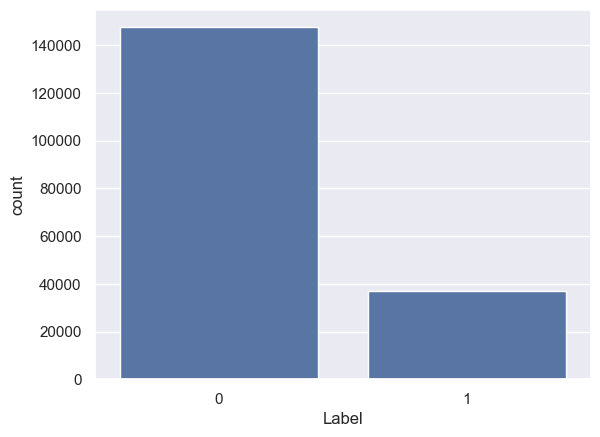

In [41]:
sns.set()
sns.countplot(hate_df, x="Label")
plt.show()

In [42]:
hate_df['char_length'] = hate_df['Review'].apply(lambda x: len(str(x)))

In [43]:
hate_df.char_length.describe()

count    184404.000000
mean        341.835204
std         550.835260
min           1.000000
25%          72.000000
50%         158.000000
75%         372.000000
max        5867.000000
Name: char_length, dtype: float64

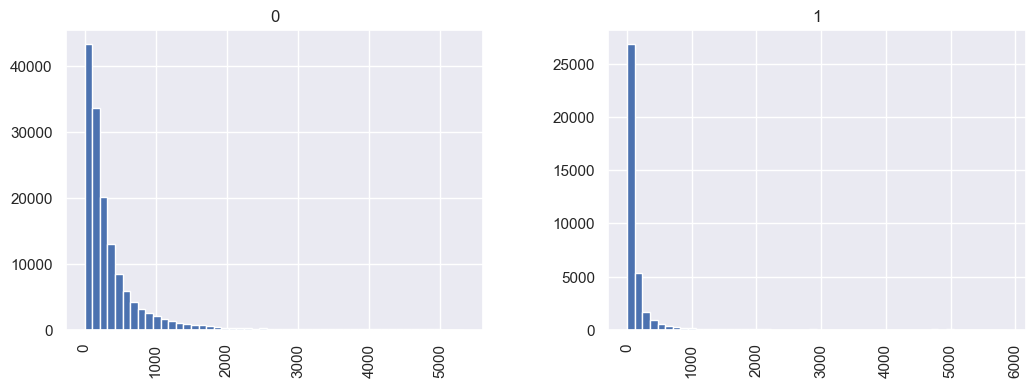

In [44]:
sns.set()
hate_df.hist(column="char_length", by="Label", figsize=(12,4), bins=50)
plt.show()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(hate_df['Review'], hate_df['Label'], test_size=0.25, random_state=42)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((138303,), (46101,), (138303,), (46101,))

In [47]:
vect = TfidfVectorizer(max_features = 10000, stop_words='english')
vect

TfidfVectorizer(max_features=10000, stop_words='english')

In [48]:
%%time 
X_train_dtm = vect.fit_transform(X_train.apply(lambda x: np.str_(x)))
X_train_dtm

CPU times: total: 5.28 s
Wall time: 5.58 s


<138303x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2743627 stored elements in Compressed Sparse Row format>

In [49]:
pickle.dump(vect, open(r"D:\Code\Data\Content Moderation Data\models\hate_vectorizer.pkl", "wb"))

In [50]:
%%time
X_test_dtm = vect.transform(X_test.apply(lambda x: np.str_(x)))
X_test_dtm

CPU times: total: 1.72 s
Wall time: 1.8 s


<46101x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 921021 stored elements in Compressed Sparse Row format>

In [51]:
logreg = LogisticRegression(C=1, max_iter = 3000)

In [52]:
# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)

LogisticRegression(C=1, max_iter=3000)

In [53]:
filename = r"D:\Code\Data\Content Moderation Data\models\hate_lr_model.pkl"
pickle.dump(logreg, open(filename, 'wb'))

In [54]:
# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)

print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))

# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)

print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))

Training accuracy is 0.9588150654721879
Test accuracy is 0.95505520487625


In [55]:
confusion_matrix(y_test,y_pred_test)

array([[36725,   271],
       [ 1801,  7304]], dtype=int64)

In [56]:
model = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\hate_lr_model.pkl", 'rb'))
vect = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\hate_vectorizer.pkl", 'rb'))

In [57]:
sen = ["Hey girl, you are such a bitch"]
sen_trans = vect.transform(sen)
p = model.predict(sen_trans)[0]
prob = model.predict_proba(sen_trans)[0]
validity = ["allowed","toxic"]
print(validity[p])
print(prob)

toxic
[5.04495972e-04 9.99495504e-01]


In [58]:
sen = ["You are so gorgeous"]
sen_trans = vect.transform(sen)
p = model.predict(sen_trans)[0]
prob = model.predict_proba(sen_trans)[0]
validity = ["allowed","toxic"]
print(validity[p])
print(prob)

allowed
[0.91594901 0.08405099]


### Abuse Classification

In [59]:
abuse_df = pd.read_csv(r"D:\Code\Data\Content Moderation Data\abuse_train.csv") 

In [60]:
abuse_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [61]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [62]:
abuse_df["comment_text"].isna().sum()

0

In [63]:
unlabelled_in_all = abuse_df[(abuse_df['toxic']!=1) & (abuse_df['severe_toxic']!=1) & (abuse_df['obscene']!=1) & 
                             (abuse_df['threat']!=1) & (abuse_df['insult']!=1) & (abuse_df['identity_hate']!=1)]

print('Percentage of unlabelled comments or good comments is ', len(unlabelled_in_all)/len(abuse_df)*100)

Percentage of unlabelled comments or good comments is  89.83211235124176


In [64]:
labelled_in_all = abuse_df[(abuse_df['toxic']==1) & (abuse_df['severe_toxic']==1) & (abuse_df['obscene']==1) & 
                           (abuse_df['threat']==1) & (abuse_df['insult']==1) & (abuse_df['identity_hate']==1)]

print('Percentage of comments which is present in all categories is ', len(labelled_in_all)/len(abuse_df)*100)

Percentage of comments which is present in all categories is  0.019427088882065038


In [65]:
print('Total rows in train is {}'.format(len(abuse_df)))
abuse_df[cols_target].sum()

Total rows in train is 159571


obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

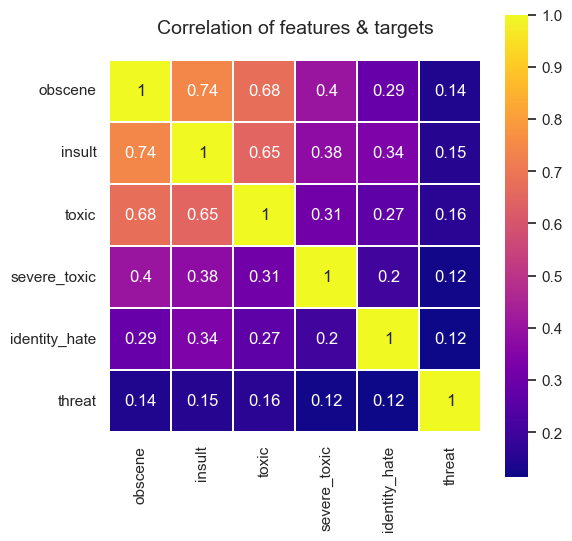

In [66]:
target_data = abuse_df[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(6,6))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(target_data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

plt.show()

In [67]:
abuse_df['block'] = abuse_df[cols_target].sum(axis=1)
abuse_df['block'].value_counts()

block
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

In [68]:
abuse_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,block
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [69]:
abuse_df['block'] = abuse_df['block'] > 0 
abuse_df['block'] = abuse_df['block'].astype(int)
abuse_df['block'].value_counts()

block
0    143346
1     16225
Name: count, dtype: int64

In [70]:
abuse_df['char_length'] = abuse_df['comment_text'].apply(lambda x: len(str(x)))

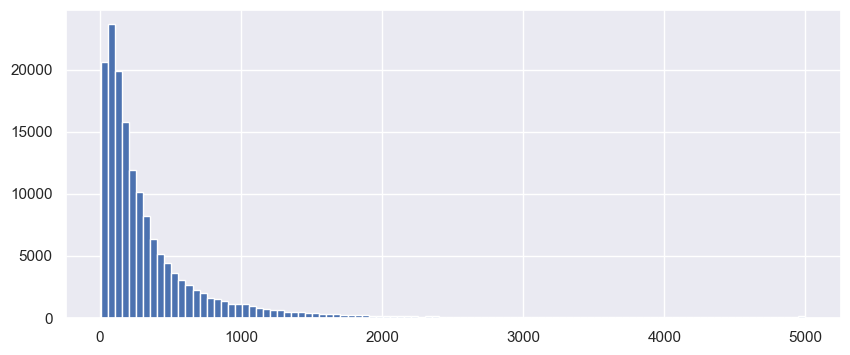

In [71]:
sns.set()
abuse_df['char_length'].hist(figsize=(10,4), bins=100)
plt.show()

In [72]:
for d in [contractions.leftovers_dict, contractions.unsafe_dict, contractions.slang_dict]:
    for k, v in d.items():
        contractions.add(k, v) 

In [73]:
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [74]:
%%time 
abuse_df['comment_text'] = abuse_df['comment_text'].map(lambda com : clean_text(com))

CPU times: total: 10.5 s
Wall time: 10.8 s


In [75]:
X_train, X_test, y_train, y_test = train_test_split(abuse_df['comment_text'], abuse_df['block'], test_size=0.2, random_state=42)

In [76]:
vect = TfidfVectorizer(max_features = 10000, stop_words='english')
vect

TfidfVectorizer(max_features=10000, stop_words='english')

In [77]:
%%time 
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

CPU times: total: 4.89 s
Wall time: 5.11 s


<127656x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2785253 stored elements in Compressed Sparse Row format>

In [78]:
pickle.dump(vect, open(r"D:\Code\Data\Content Moderation Data\models\abuse_vectorizer.pkl", "wb"))

In [79]:
%%time
X_test_dtm = vect.transform(X_test)
X_test_dtm

CPU times: total: 1.27 s
Wall time: 1.39 s


<31915x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 686572 stored elements in Compressed Sparse Row format>

In [80]:
logreg = LogisticRegression(C=1, max_iter = 2000)

In [81]:
# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)

filename = r"D:\Code\Data\Content Moderation Data\models\abuse_lr_model.pkl"
pickle.dump(logreg, open(filename, 'wb'))

# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))

# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))

Training accuracy is 0.9595632011029642
Test accuracy is 0.9564154786150713


In [82]:
confusion_matrix(y_test,y_pred_test)

array([[28508,   163],
       [ 1228,  2016]], dtype=int64)

In [83]:
sen = ["YOU MORON LEAVE BEFORE YOU PISS AROUND ON MY WORK"]
sen_trans = vect.transform(sen)
p = logreg.predict(sen_trans)[0]
validity = ["allowed","toxic"]
print(validity[p])

toxic


### Toxicity Classification

In [19]:
toxic_texts = [
    "its common sense moron, it was a fight in the wec",
    "She is an absolute bitch lady",
    "being single is not an excuse to be a imbecile ",
    "Whenever the teacher fucking tells him that he has homework this bloody idiot needs to go to washroom",
    "At this point I know it's outside of the warranty period but this is obviously a fire hazard.",
    "I am going to kill you if you don't do as I say",
    "She called him a black fat idiot in front of everyone",
    "Mate, do not piss me off you are driving me insane go away",
    "You are so stupid, even a kid looks smart infront of you"
]

In [20]:
det = Detoxify('unbiased')

In [22]:
det.predict(text)

{'toxicity': 0.0003664828,
 'severe_toxicity': 1.4843088e-06,
 'obscene': 2.7198139e-05,
 'identity_attack': 6.980224e-05,
 'insult': 9.1837086e-05,
 'threat': 1.8658204e-05,
 'sexual_explicit': 1.4753326e-05}

In [87]:
for text in toxic_texts:
    print(text)
    text = " ".join(text.splitlines())
    toxicity = det.predict(text)
    toxicity = {k: round(v, 3) for k, v in toxicity.items()}
    print(toxicity, "\n")

its common sense moron, it was a fight in the wec
{'toxicity': 0.989, 'severe_toxicity': 0.0, 'obscene': 0.013, 'identity_attack': 0.001, 'insult': 0.982, 'threat': 0.0, 'sexual_explicit': 0.0} 

She is an absolute bitch lady
{'toxicity': 0.992, 'severe_toxicity': 0.058, 'obscene': 0.947, 'identity_attack': 0.041, 'insult': 0.945, 'threat': 0.001, 'sexual_explicit': 0.108} 

being single is not an excuse to be a imbecile 
{'toxicity': 0.991, 'severe_toxicity': 0.0, 'obscene': 0.002, 'identity_attack': 0.002, 'insult': 0.987, 'threat': 0.0, 'sexual_explicit': 0.0} 

Whenever the teacher fucking tells him that he has homework this bloody idiot needs to go to washroom
{'toxicity': 0.997, 'severe_toxicity': 0.109, 'obscene': 0.969, 'identity_attack': 0.021, 'insult': 0.945, 'threat': 0.003, 'sexual_explicit': 0.064} 

At this point I know it's outside of the warranty period but this is obviously a fire hazard.
{'toxicity': 0.001, 'severe_toxicity': 0.0, 'obscene': 0.0, 'identity_attack': 0

### Profanity Check

In [88]:
sen = "dont be b1tchy"
censored = profanity.censor(sen)
print(censored)

dont be b1tchy


In [89]:
sen = "dont be a bitch"
censored = profanity.censor(sen)
print(censored)

dont be a ****


In [90]:
custom_badwords = ['anal', 'wanna suck', 'merry','b1tchy']
# profanity.load_censor_words(custom_badwords)
profanity.add_censor_words(custom_badwords)

In [91]:
sen = "dont be stupid b1tchy bitch"
censored = profanity.censor(sen)
print(censored)

dont be **** **** ****


In [92]:
profanity_df = pd.read_csv(r"D:\Code\Data\Content Moderation Data\profanity_en.csv")

In [93]:
profanity_df.head()

,text,canonical_form_1,canonical_form_2,canonical_form_3,category_1,category_2,category_3,severity_rating,severity_description
0,69,69,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild
1,@55,ass,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild
2,@ssfcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe
3,@ssfucker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe
4,@ssfvcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.4,Strong


In [94]:
profanity_df['severity_rating'].describe()

count    1598.000000
mean        2.028160
std         0.645068
min         1.000000
25%         1.400000
50%         2.000000
75%         2.600000
max         3.000000
Name: severity_rating, dtype: float64

In [95]:
list_bad_words = profanity_df['text'].values.tolist()
list_bad_words[50:55]

['arsehole', 'arseshit', 'arsewipe', 'ashole', 'ass']

In [96]:
profanity.add_censor_words(list_bad_words)

In [97]:
pickle.dump(profanity, open(r"D:\Code\Data\Content Moderation Data\models\Profanity_cust.pkl", "wb"))

In [98]:
Profanity_model = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\Profanity_cust.pkl", 'rb'))

In [99]:
sen = "dont be stupid b1tchy"
censored = Profanity_model.censor(sen)
print(censored)

dont be **** ****


### Badwords Identification

In [100]:
bad_df = pd.read_csv(r"D:\Code\Data\Content Moderation Data\bad-words.csv", header=None)

In [101]:
bad_df.head()

,0
0,jigaboo
1,mound of venus
2,asslover
3,s&m
4,queaf


In [102]:
badwords = bad_df[0].values.tolist()
badwords

['jigaboo',
 'mound of venus',
 'asslover',
 's&m',
 'queaf',
 'whitetrash',
 'meatrack',
 'ra8s',
 'pimp',
 'urine',
 'whit',
 'randy',
 'herpes',
 'niglet',
 'narcotic',
 'pudboy',
 'rimming',
 'boner',
 'pornography',
 'poop chute',
 'israel',
 'dong',
 'slanteye',
 'muffdiving',
 'jiggabo',
 'assassination',
 'peepshpw',
 'popimp',
 'girl on',
 'testicles',
 'laid',
 'molestor',
 'peni5',
 'tranny',
 'barface',
 'hell',
 'arsehole',
 'pissed',
 'sixsixsix',
 'execute',
 'shitty ',
 'conspiracy',
 'hamas',
 'cunilingus',
 'bitcher',
 'muslim',
 'pee',
 'niggled',
 'muffindiver',
 'cocksman',
 'scag',
 'aroused',
 'niggling',
 'fingerfucker ',
 'nlggor',
 'niggaz',
 'assfuck',
 'slant',
 'urinate',
 'mothafucked ',
 'fungus',
 'retard',
 'gummer',
 'venus mound',
 'alla',
 'spaghettinigger',
 'piss',
 'mickeyfinn',
 'fuckers',
 'jizzim',
 'tramp',
 'quashie',
 'prince albert piercing',
 'hardon',
 'menage a trois',
 'bukkake',
 'shag',
 'australian',
 'raped',
 'buggery',
 'deth',
 '

In [103]:
badwords.extend([
'2g1c',
'2 girls 1 cup',
'acrotomophilia',
'anal',
'anilingus',
'anus',
'arsehole',
'ass',
'asshole',
'assmunch',
'auto erotic',
'autoerotic',
'babeland',
'baby batter',
'ball gag',
'ball gravy',
'ball kicking',
'ball licking',
'ball sack',
'ball sucking',
'bangbros',
'bareback',
'barely legal',
'barenaked',
'bastardo',
'bastinado',
'bbw',
'bdsm',
'beaver cleaver',
'beaver lips',
'bestiality',
'bi curious',
'big black',
'big breasts',
'big knockers',
'big tits',
'bimbos',
'birdlock',
'bitch',
'black cock',
'blonde action',
'blonde on blonde action',
'blow j',
'blow your l',
'blue waffle',
'blumpkin',
'bollocks',
'bondage',
'boner',
'boob',
'boobs',
'booty call',
'brown showers',
'brunette action',
'bukkake',
'bulldyke',
'bullet vibe',
'bung hole',
'bunghole',
'busty',
'butt',
'buttcheeks',
'butthole',
'camel toe',
'camgirl',
'camslut',
'camwhore',
'carpet muncher',
'carpetmuncher',
'chocolate rosebuds',
'circlejerk',
'cleveland steamer',
'clit',
'clitoris',
'clover clamps',
'clusterfuck',
'cock',
'cocks',
'coprolagnia',
'coprophilia',
'cornhole',
'cum',
'cumming',
'cunnilingus',
'cunt',
'darkie',
'date rape',
'daterape',
'deep throat',
'deepthroat',
'dick',
'dildo',
'dirty pillows',
'dirty sanchez',
'dog style',
'doggie style',
'doggiestyle',
'doggy style',
'doggystyle',
'dolcett',
'domination',
'dominatrix',
'dommes',
'donkey punch',
'double dong',
'double penetration',
'dp action',
'eat my ass',
'ecchi',
'ejaculation',
'erotic',
'erotism',
'escort',
'ethical slut',
'eunuch',
'faggot',
'fecal',
'felch',
'fellatio',
'feltch',
'female squirting',
'femdom',
'figging',
'fingering',
'fisting',
'foot fetish',
'footjob',
'frotting',
'fuck',
'fucking',
'fuck buttons',
'fudge packer',
'fudgepacker',
'futanari',
'g-spot',
'gang bang',
'gay sex',
'genitals',
'giant cock',
'girl on',
'girl on top',
'girls gone wild',
'goatcx',
'goatse',
'gokkun',
'golden shower',
'goo girl',
'goodpoop',
'goregasm',
'grope',
'group sex',
'guro',
'hand job',
'handjob',
'hard core',
'hardcore',
'hentai',
'homoerotic',
'honkey',
'hooker',
'hot chick',
'how to kill',
'how to murder',
'huge fat',
'humping',
'incest',
'intercourse',
'jack off',
'jail bait',
'jailbait',
'jerk off',
'jigaboo',
'jiggaboo',
'jiggerboo',
'jizz',
'juggs',
'kike',
'kinbaku',
'kinkster',
'kinky',
'knobbing',
'leather restraint',
'leather straight jacket',
'lemon party',
'lolita',
'lovemaking',
'make me come',
'male squirting',
'masturbate',
'menage a trois',
'milf',
'missionary position',
'motherfucker',
'mound of venus',
'mr hands',
'muff diver',
'muffdiving',
'nambla',
'nawashi',
'negro',
'neonazi',
'nig nog',
'nigga',
'nigger',
'nimphomania',
'nipple',
'nipples',
'nsfw images',
'nude',
'nudity',
'nympho',
'nymphomania',
'octopussy',
'omorashi',
'one cup two girls',
'one guy one jar',
'orgasm',
'orgy',
'paedophile',
'panties',
'panty',
'pedobear',
'pedophile',
'pegging',
'penis',
'phone sex',
'piece of shit',
'piss pig',
'pissing',
'pisspig',
'playboy',
'pleasure chest',
'pole smoker',
'ponyplay',
'poof',
'poop chute',
'poopchute',
'porn',
'porno',
'pornography',
'prince albert piercing',
'pthc',
'pubes',
'pussy',
'queaf',
'raghead',
'raging boner',
'rape',
'raping',
'rapist',
'rectum',
'reverse cowgirl',
'rimjob',
'rimming',
'rosy palm',
'rosy palm and her 5 sisters',
'rusty trombone',
's&m',
'sadism',
'scat',
'schlong',
'scissoring',
'semen',
'sex',
'sexo',
'sexy',
'shaved beaver',
'shaved pussy',
'shemale',
'shibari',
'shit',
'shota',
'shrimping',
'slanteye',
'slut',
'smut',
'snatch',
'snowballing',
'sodomize',
'sodomy',
'spic',
'spooge',
'spread legs',
'strap on',
'strapon',
'strappado',
'strip club',
'style doggy',
'suck',
'sucks',
'suicide girls',
'sultry women',
'swastika',
'swinger',
'tainted love',
'taste my',
'tea bagging',
'threesome',
'throating',
'tied up',
'tight white',
'tit',
'tits',
'titties',
'titty',
'tongue in a',
'topless',
'tosser',
'towelhead',
'tranny',
'tribadism',
'tub girl',
'tubgirl',
'tushy',
'twat',
'twink',
'twinkie',
'two girls one cup',
'undressing',
'upskirt',
'urethra play',
'urophilia',
'vagina',
'venus mound',
'vibrator',
'violet blue',
'violet wand',
'vorarephilia',
'voyeur',
'vulva',
'wank',
'wet dream',
'wetback',
'white power',
'women rapping',
'wrapping men',
'wrinkled starfish',
'xx',
'xxx',
'yaoi',
'yellow showers',
'yiffy',
'zoophilia'])

In [104]:
badwordset = set(badwords)

In [105]:
pickle.dump(badwordset,open(r"D:\Code\Data\Content Moderation Data\models\bwset.pkl","wb"))

In [106]:
bwset = pickle.load(open(r"D:\Code\Data\Content Moderation Data\models\bwset.pkl","rb"))

In [107]:
# return true if string contains any bad word
def ifbadword(string):
    for i in string.split():
        if i in bwset:
            return True
    return False

In [108]:
sen = "dont be stupid b1tchy"
ifbadword(sen)

True

### Custom NER

In [109]:
nlp = spacy.load('en_core_web_lg')

In [113]:
db = DocBin()

In [115]:
with open(r'D:\Code\Data\Content Moderation Data\ner_annotations\annotations.json') as f:
    TRAIN_DATA = json.load(f)

TRAIN_DATA

{'classes': ['ABUSIVE',
  'SEXUALLY EXPLICIT',
  'SUGGESTIVE',
  'VIOLENCE',
  'WARNING',
  'INSULT'],
 'annotations': [['I would never have guessed you had tits that big under your scrubs\r',
   {'entities': [[35, 39, 'SEXUALLY EXPLICIT'],
     [60, 66, 'SEXUALLY EXPLICIT']]}],
  ['Those nipples are amazing!\r',
   {'entities': [[6, 13, 'SEXUALLY EXPLICIT']]}],
  ['Doctors that buy their tits always show them off.\r',
   {'entities': [[23, 27, 'SEXUALLY EXPLICIT']]}],
  ['You forgot to add Hot in there, "Hot young physician"\r',
   {'entities': [[33, 36, 'SUGGESTIVE']]}],
  ['M2 checking in, I wish all my attending were this sexy \r',
   {'entities': [[50, 54, 'SUGGESTIVE']]}],
  ['I fucking love all these nurses posting pics in scrubs. Itï¿½s the best new trend.\r',
   {'entities': [[2, 9, 'ABUSIVE'], [48, 55, 'SEXUALLY EXPLICIT']]}],
  ['Edit: Physician, cause I was thinking with the wrong head.\r',
   {'entities': [[47, 57, 'SUGGESTIVE']]}],
  ['Your gorgeous, nice breasts, good lu

In [117]:
for text, annot in tqdm_notebook(TRAIN_DATA['annotations']): 
    doc = nlp.make_doc(text) 
    ents = []
    for start, end, label in annot["entities"]:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents 
    db.add(doc)

db.to_disk(r"D:\Code\Data\Content Moderation Data\models\ner_training_data.spacy") # save the docbin object

  0%|          | 0/129 [00:00<?, ?it/s]

Skipping entity


In [122]:
!python -m spacy init config ../models/ner_config.cfg --lang en --pipeline ner --optimize efficiency

[!] To generate a more effective transformer-based config (GPU-only), install
the spacy-transformers package and re-run this command. The config generated now
does not use transformers.
[i] Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
[+] Auto-filled config with all values
[+] Saved config
..\models\ner_config.cfg
You can now add your data and train your pipeline:
python -m spacy train ner_config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [124]:
!python -m spacy train ../models/ner_config.cfg --output ../models/ --paths.train ../models/ner_training_data.spacy --paths.dev ../models/ner_training_data.spacy

[i] Saving to output directory: ..\models
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     43.62    0.00    0.00    0.00    0.00
  4     200        322.18   2975.12   82.33   83.21   81.47    0.82
  9     400        189.64    616.28   97.21   96.88   97.55    0.97
 15     600        133.51    138.95  100.00  100.00  100.00    1.00
 23     800         70.10     44.21  100.00  100.00  100.00    1.00
 32    1000         87.21     42.07   99.48   99.30   99.65    0.99
 43    1200         48.69     18.43  100.00  100.00  100.00    1.00
 56    1400         31.59      7.48  100.00  100.00  100.00    1.00
 71    1600       

In [125]:
nlp_cus_ner = spacy.load("../models/model-best")

In [126]:
text = '''No, you are the racist, you goddamn neo-Nazi    YOU BIG BOY
I had enough of *you*, bastard.
Alyssaa oconnor is reatrded
Hey I'm just tellin' like it is you ugly as fuck butt fugly muthafucka!
You ignoramus! My cousin just did the hitler pictures and the swastikas and what not. 
I've been the one talking to you you imbecile. I can't believe that people that are stupid like you exist.
It makes we want to start playing russian roulette with myself.'''

In [127]:
doc = nlp_cus_ner(text)

In [128]:
for token in doc.ents:
    print(token.text,token.label_)

racist INSULT
neo-Nazi INSULT
bastard ABUSIVE
ugly INSULT
fuck ABUSIVE
butt ABUSIVE
fugly ABUSIVE
muthafucka ABUSIVE
swastikas SUGGESTIVE
imbecile INSULT


In [129]:
spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter

In [130]:
text = '''I would never have guessed you had tits that big under your scrubs						
damn	 I'd set that ass out to thaw	 brine in salt for a day or two until I'm left with moist	 juicy white meat	 rub it with some salt and pepper	 put it in the oven 13 minutes per pound at 450 degrees	 before placing that shit on a platter and digging in. **ðŸ¥µ**
Anytime	 anywhere	 whenever I'm in the mood or get the urge	 look for you walking around naked	 then grab you	 stuff that pussy	 then fuck your brains out. Would do it multiple times a day.
Pearly white teeth	 luscious lips	 gorgeous smile	 AMAZING tits	 a tight and toned stomach	 lovely hips	 sexy tan lines and a smooth pussy peeking out :).  What a body babe!!
'''

In [131]:
doc = nlp_cus_ner(text)
for token in doc.ents:
     print(token.text,token.label_)

tits SEXUALLY EXPLICIT
scrubs SEXUALLY EXPLICIT
ass SEXUALLY EXPLICIT
pepper INSULT
degrees INSULT
naked SUGGESTIVE
pussy SEXUALLY EXPLICIT
fuck ABUSIVE
tits SEXUALLY EXPLICIT
sexy SUGGESTIVE
pussy SEXUALLY EXPLICIT


In [132]:
spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter

In [133]:
pickle.dump(nlp_cus_ner, open("D:/Code/Data/Content Moderation Data/models/cus_ner.pkl", "wb" ))

In [134]:
TRAIN_DATA['annotations']

[['I would never have guessed you had tits that big under your scrubs\r',
  {'entities': [[35, 39, 'SEXUALLY EXPLICIT'],
    [60, 66, 'SEXUALLY EXPLICIT']]}],
 ['Those nipples are amazing!\r',
  {'entities': [[6, 13, 'SEXUALLY EXPLICIT']]}],
 ['Doctors that buy their tits always show them off.\r',
  {'entities': [[23, 27, 'SEXUALLY EXPLICIT']]}],
 ['You forgot to add Hot in there, "Hot young physician"\r',
  {'entities': [[33, 36, 'SUGGESTIVE']]}],
 ['M2 checking in, I wish all my attending were this sexy \r',
  {'entities': [[50, 54, 'SUGGESTIVE']]}],
 ['I fucking love all these nurses posting pics in scrubs. Itï¿½s the best new trend.\r',
  {'entities': [[2, 9, 'ABUSIVE'], [48, 55, 'SEXUALLY EXPLICIT']]}],
 ['Edit: Physician, cause I was thinking with the wrong head.\r',
  {'entities': [[47, 57, 'SUGGESTIVE']]}],
 ['Your gorgeous, nice breasts, good luck with your medical career \r',
  {'entities': [[5, 13, 'SUGGESTIVE'], [20, 27, 'SEXUALLY EXPLICIT']]}],
 ['Hot Hershey nipples,  Del